# ANÁLISIS EXPLORATORIO DE LOS DATOS

En esta sección vamos a realizar un analisis más profundo para poder encontrar relaciones entre variables. Haremos uso de estadística descriptiva y gráficos como herramientas.

In [6]:
# Instalación de librería para leer archivos RData
!pip install pyreadr pandas numpy

import pyreadr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Configuración de visualizaciones
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

Defaulting to user installation because normal site-packages is not writeable


## 1. Carga, Fusión y Etiquetado del Dataset TEP

Aquí se cargan los cuatro archivos .RData y se consolidan en un único DataFrame de trabajo

In [17]:
# --------------------------------------
# Función para cargar RData
# --------------------------------------
def load_rdata(file_path):
    """Carga un archivo .RData usando pyreadr y extrae el DataFrame."""
    try:
        result = pyreadr.read_r(file_path)
        # El DataFrame se almacena bajo una clave que es el nombre del objeto R
        df_name = list(result.keys())[0]
        return result[df_name]
    except Exception as e:
        print(f"Error al cargar {file_path}: {e}")
        return pd.DataFrame()

# --------------------------------------
# Rutas de los datasets 
# --------------------------------------
file_paths = {
    "Fault Free Training": "TEP_FaultFree_Training.RData",
    "Faulty Training": "TEP_Faulty_Training.RData",
    "Fault Free Testing": "TEP_FaultFree_Testing.RData",
    "Faulty Testing": "TEP_Faulty_Testing.RData"
}

# Cargar datasets
datasets = {name: load_rdata(path) for name, path in file_paths.items()}

# --------------------------------------
# CREACIÓN DE CONJUNTOS DE ENTRENAMIENTO Y PRUEBA
# --------------------------------------

# 1. Conjunto de Entrenamiento (Uniendo datos sin y con fallo)
train_datasets = [
    datasets["Fault Free Training"].assign(Origen='Fault Free Training'),
    datasets["Faulty Training"].assign(Origen='Faulty Training')
]
df_train_raw = pd.concat([df for df in train_datasets if not df.empty], ignore_index=True)
df_train_raw['fault_present'] = np.where(df_train_raw['faultNumber'] > 0, 1, 0) # 0:Normal, 1:Fallo

# 2. Conjunto de Prueba (Uniendo datos sin y con fallo)
test_datasets = [
    datasets["Fault Free Testing"].assign(Origen='Fault Free Testing'),
    datasets["Faulty Testing"].assign(Origen='Faulty Testing')
]
df_test_raw = pd.concat([df for df in test_datasets if not df.empty], ignore_index=True)
df_test_raw['fault_present'] = np.where(df_test_raw['faultNumber'] > 0, 1, 0) # 0:Normal, 1:Fallo

print(f"Muestras para Entrenamiento (RAW): {len(df_train_raw)}")
print(f"Muestras para Prueba (RAW): {len(df_test_raw)}")

# Vista rápida de la estructura del conjunto de entrenamiento
print("\nEstructura del DataFrame de Entrenamiento:")
df_train_raw.info()

Muestras para Entrenamiento (RAW): 5250000
Muestras para Prueba (RAW): 10080000

Estructura del DataFrame de Entrenamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5250000 entries, 0 to 5249999
Data columns (total 57 columns):
 #   Column         Dtype  
---  ------         -----  
 0   faultNumber    float64
 1   simulationRun  float64
 2   sample         int32  
 3   xmeas_1        float64
 4   xmeas_2        float64
 5   xmeas_3        float64
 6   xmeas_4        float64
 7   xmeas_5        float64
 8   xmeas_6        float64
 9   xmeas_7        float64
 10  xmeas_8        float64
 11  xmeas_9        float64
 12  xmeas_10       float64
 13  xmeas_11       float64
 14  xmeas_12       float64
 15  xmeas_13       float64
 16  xmeas_14       float64
 17  xmeas_15       float64
 18  xmeas_16       float64
 19  xmeas_17       float64
 20  xmeas_18       float64
 21  xmeas_19       float64
 22  xmeas_20       float64
 23  xmeas_21       float64
 24  xmeas_22       float64
 25  xm

Los datos de entrenamiento y prueba tienen 5.25M y 10.08M de muestras respectivamente, cada una etiquetada según la presencia de fallos.

## 2. Preparación de Datos y Verificación

Se verifica la estructura, tipos de datos y la ausencia de valores nulos (confirmando el análisis inicial).

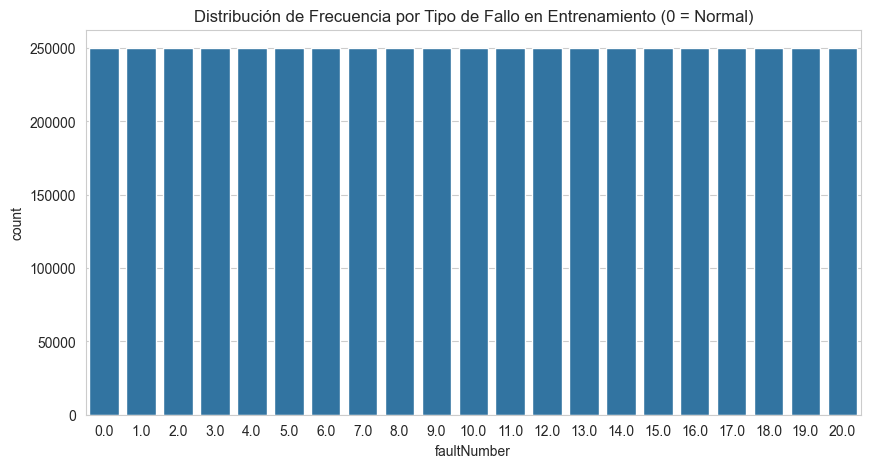

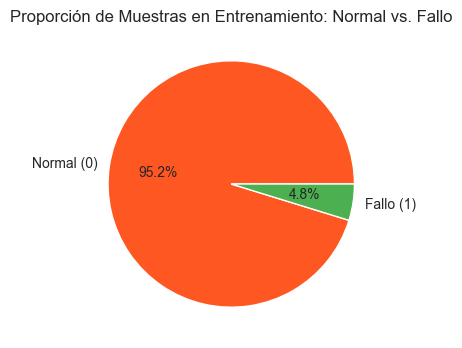

In [23]:
# 1. Distribución de faultNumber (Multi-clase)
plt.figure(figsize=(10, 5))
sns.countplot(x='faultNumber', data=df_train_raw)
plt.title('Distribución de Frecuencia por Tipo de Fallo en Entrenamiento (0 = Normal)')
plt.show()

# 2. Distribución Binaria (Fallo vs. Normal)
fault_counts = df_train_raw['fault_present'].value_counts()
plt.figure(figsize=(4, 4))
fault_counts.plot.pie(
    autopct='%1.1f%%', 
    labels=['Fallo (1)', 'Normal (0)'] if fault_counts.iloc[0] == 1 else ['Normal (0)', 'Fallo (1)'], 
    colors=['#FF5722', '#4CAF50']
)
plt.ylabel('')
plt.title('Proporción de Muestras en Entrenamiento: Normal vs. Fallo')
plt.show()

La distribución de faultNumber muestra que todas las clases de fallo están representadas, que sugieren una simulación balanceada. 
    
A nivel binario, el conjunto de entrenamiento presenta una fuerte desbalance, con un 95.2% de muestras normales y solo 4.8% con fallo, lo que indica que será necesario aplicar técnicas para manejar el desbalance al entrenar modelos de clasificación.

## 3. Análisis Exploratorio de Datos (EDA)

El EDA se realizará principalmente sobre el conjunto de entrenamiento para entender la dinámica del proceso.

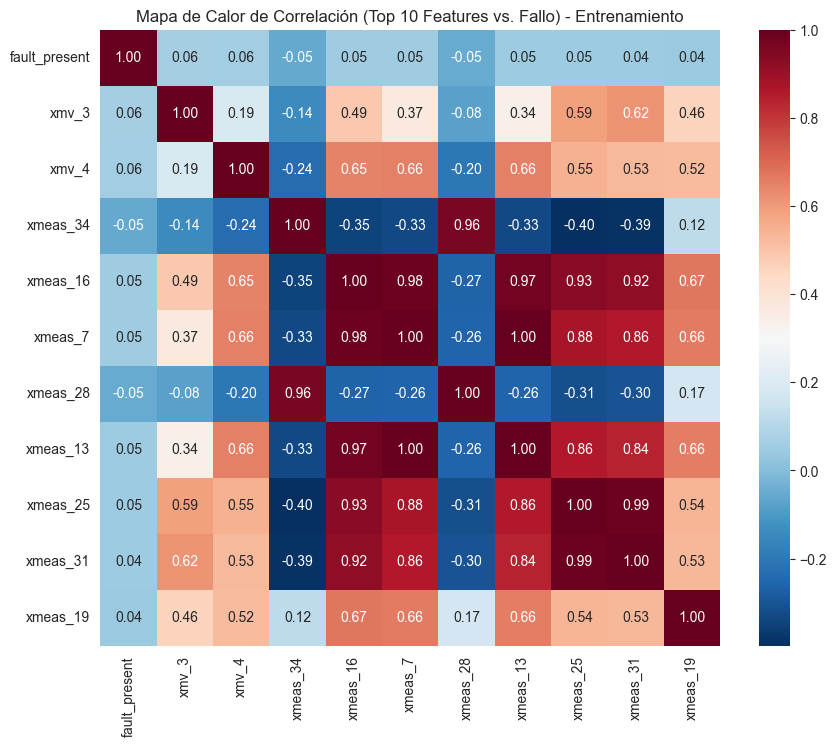

In [19]:
# Seleccionar solo variables de proceso/manipuladas
process_vars = [col for col in df_train_raw.columns if 'xmeas' in col or 'xmv' in col]
cols_to_corr = process_vars + ['fault_present']

corr_matrix = df_train_raw[cols_to_corr].corr()

# Mostrar Heatmap de correlación (limitado a las 10 variables más correlacionadas con el fallo)
high_corr_features = corr_matrix['fault_present'].abs().sort_values(ascending=False).index[:11]
plt.figure(figsize=(10, 8))
sns.heatmap(
    df_train_raw[high_corr_features].corr(), 
    annot=True, 
    fmt=".2f", 
    cmap='RdBu_r'
)
plt.title('Mapa de Calor de Correlación (Top 10 Features vs. Fallo) - Entrenamiento')
plt.show()

# Conclusión: Se identifican los predictores más fuertes para la fase de modelado.


Las correlaciones con la variable fault_present son muy bajas, indicando que ningún sensor o variable manipulada presenta una relación lineal fuerte con la presencia de fallos. Por otro lado, si se muestra correlación entre otras variables, lo cual puede indicar redundancia en las mediciones. Para el proyecto, esto quiere decir que podemos aplicar selección de variables o reducción de dimensiones durante el modelado.

### 3.2. Análisis de Series Temporales (Ejemplo)

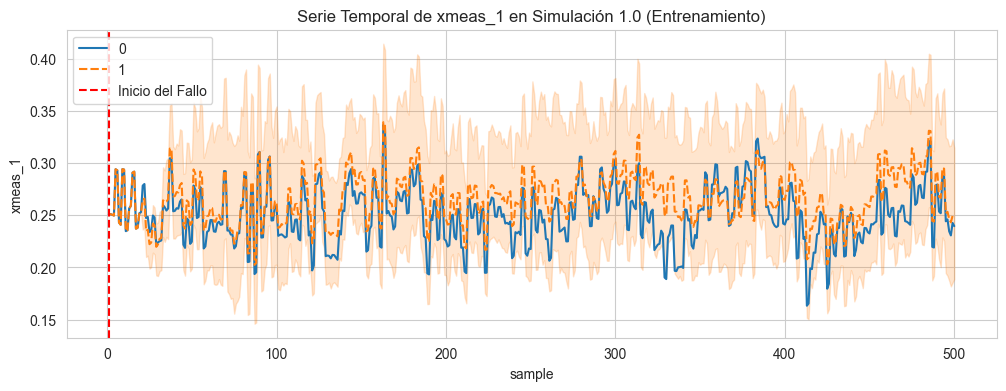

In [24]:
# Seleccionar una simulación con un fallo conocido (ejemplo: la primera simulación con fallo)
simulation_run = df_train_raw[df_train_raw['fault_present'] == 1]['simulationRun'].iloc[0]
df_sim_fault = df_train_raw[df_train_raw['simulationRun'] == simulation_run].copy()

# Variable (ejemplo de xmeas_1)
key_variable = 'xmeas_1'

plt.figure(figsize=(12, 4))
sns.lineplot(x='sample', y=key_variable, data=df_sim_fault, hue='fault_present', style='fault_present', markers=False)

# Marcar el inicio de la inyección del fallo
fault_start_sample = df_sim_fault[df_sim_fault['fault_present'] == 1]['sample'].min()
if pd.notna(fault_start_sample):
    plt.axvline(x=fault_start_sample, color='r', linestyle='--', label='Inicio del Fallo')

plt.title(f'Serie Temporal de {key_variable} en Simulación {simulation_run} (Entrenamiento)')
plt.legend()
plt.show()


Aqui podemos ver que la variable xmeans_1 tiene un alto nivel de ruido, pero el valor de la clase fallo tiene valores ligeramente superiores. 

El rango de variación del fallo (la sombra naranja) es mucho más amplio que la clase normal, lo que indica un aumento en la desviación e inestabilidad del proceso después del comienzo del fallo.